# **Emotion Detection using ANN VS LSTM**

In this project, our first task is to detect the user's emotion / mood based on the input they provide and classify it using Deep Learning models.
We compare two architectures ANN & LSTM and and evaluate their performance to identify which model achieves the highest accuracy.

Here, we've used **'Emotion-Dataset'** which includes six emotion categories —
- 0 - sadness
- 1 - joy
- 2 - love
- 3 - anger
- 4 - fear
- 5 - surprise


## **Importing necessary Libraries**

In [28]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, LSTM, Bidirectional, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle
import json

## **Loading the Dataset**

In [4]:
train_data = pd.read_csv("/content/training.csv")
test_data = pd.read_csv("/content/test.csv")
val_data = pd.read_csv("/content/validation.csv")

print(train_data.head())
print(train_data['label'].value_counts())

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


## **Data Exploration & Visualization**

In [5]:
print(f"Validation data: {val_data.shape}")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

half_test_data = test_data.iloc[1000:]
test_data = test_data.iloc[:1000]
val_data = pd.concat([val_data, half_test_data], axis=0)

print(f"New Validation data: {val_data.shape}")
print(f"New Test data: {test_data.shape}")

labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)

Validation data: (2000, 2)
Training data: (16000, 2)
Test data: (2000, 2)
New Validation data: (3000, 2)
New Test data: (1000, 2)


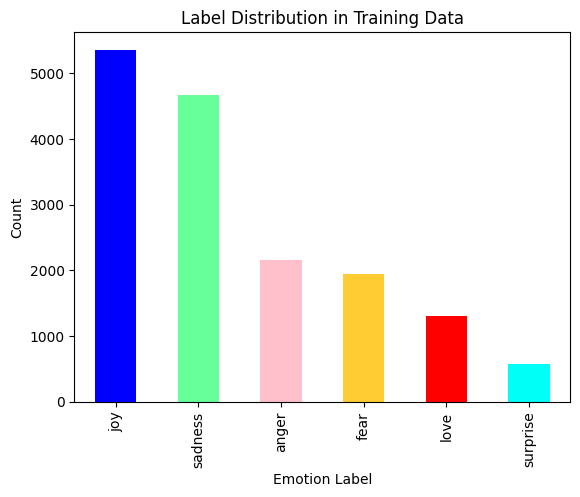

In [6]:
train_data['label_name'].value_counts().plot(kind='bar', color=['blue', '#66FF99', 'pink', '#FFCC33', 'red', '#00fff7'])
plt.title('Label Distribution in Training Data')
plt.ylabel('Count')
plt.xlabel('Emotion Label')
plt.show()

In [7]:
print(train_data.isnull().sum())
print(val_data.isnull().sum())
print(test_data.isnull().sum())

text          0
label         0
label_name    0
dtype: int64
text     0
label    0
dtype: int64
text     0
label    0
dtype: int64


## **Data Preprocessing**

- Lowercase all text

- Remove punctuation and special characters

- Remove stopwords

- Stemming

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"http\S+|@\S+|#\S+|[^a-zA-Z\s]", '', text)
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return " ".join(tokens)
    else:
        return ""

train_data['text'] = train_data['text'].fillna('')
test_data['text'] = test_data['text'].fillna('')
val_data['text'] = val_data['text'].fillna('')

train_data['clean_text'] = train_data['text'].apply(preprocess)
test_data['clean_text'] = test_data['text'].apply(preprocess)
val_data['clean_text'] = val_data['text'].apply(preprocess)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### **Tokenization**

In [9]:
tokenize = Tokenizer(num_words=160000, oov_token='<OOV>')
tokenize.fit_on_texts(train_data['clean_text'])

X_train_seq = tokenize.texts_to_sequences(train_data['clean_text'])
X_test_seq = tokenize.texts_to_sequences(test_data['clean_text'])
X_val_seq = tokenize.texts_to_sequences(val_data['clean_text'])

max = max(len(x) for x in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max, padding='post')

### **Label Encoding**

In [10]:
labels = LabelEncoder()
y_train = labels.fit_transform(train_data['label'])
y_train_cat = to_categorical(y_train)
y_test = labels.transform(test_data['label'])
y_test_cat = to_categorical(y_test)
y_val = labels.transform(val_data['label'])
y_val_cat = to_categorical(y_val)

# **ANN**

## **Build & Train model**

In [11]:
model = Sequential([
    Embedding(input_dim=16000, output_dim=64, input_length=max),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax')
])
optimizer = Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train_pad, y_train_cat, epochs=10, validation_data=(X_val_pad, y_val_cat), verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3783 - loss: 1.5346 - val_accuracy: 0.7543 - val_loss: 0.8233
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8229 - loss: 0.5366 - val_accuracy: 0.8147 - val_loss: 0.5035
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9250 - loss: 0.2392 - val_accuracy: 0.8357 - val_loss: 0.4783
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9419 - loss: 0.1774 - val_accuracy: 0.8493 - val_loss: 0.4640
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9559 - loss: 0.1347 - val_accuracy: 0.8267 - val_loss: 0.5630
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9575 - loss: 0.1223 - val_accuracy: 0.8353 - val_loss: 0.5727
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9645 - loss: 0.1037 - val_accuracy: 0.8350 - val_loss: 0.5658
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9665 - loss: 0.0970 - val_accuracy: 0.8473 - 

### **Test Accuracy of ANN**

In [12]:
loss, accuracy = model.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8483 - loss: 0.6047
Test Accuracy: 83.60%


### **ANN Model Parameters**

In [13]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (32, 35, 64)           │     1,024,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (32, 64)               │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (32, 64)               │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,085,652 (11.77 MB)

 Trainable params: 1,028,550 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,057,102 (7.85 MB)

## **Evaluation & Prediction**

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:

              precision    recall  f1-score   support

     sadness       0.89      0.88      0.89       295
         joy       0.83      0.91      0.87       337
       anger       0.72      0.55      0.63        83
        love       0.84      0.81      0.83       140
        fear       0.81      0.78      0.80       115
    surprise       0.71      0.67      0.69        30

    accuracy                           0.84      1000
   macro avg       0.80      0.77      0.78      1000
weighted avg       0.83      0.84      0.83      1000



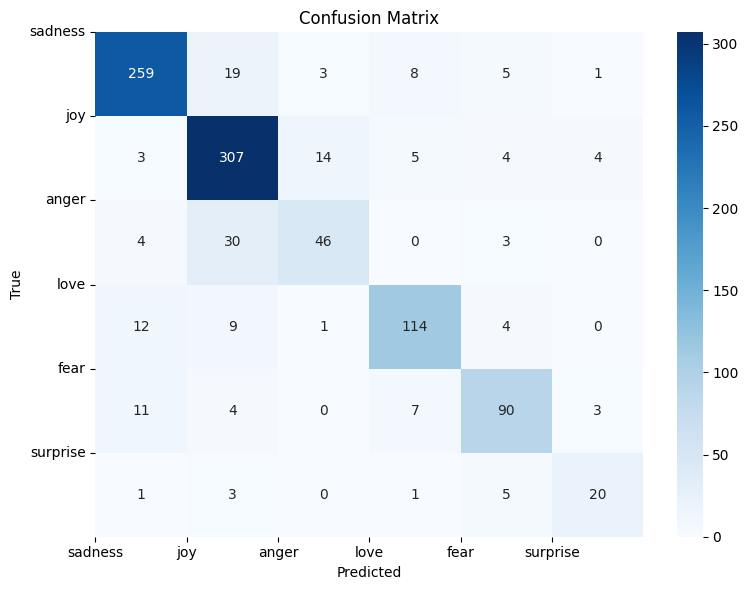

In [14]:
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

emotion_labels = ['sadness', 'joy', 'anger', 'love', 'fear', 'surprise']

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xticks(ticks=np.arange(len(emotion_labels)), labels=emotion_labels, rotation=0)
plt.yticks(ticks=np.arange(len(emotion_labels)), labels=emotion_labels, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### **Accuracy vs Loss Plot**

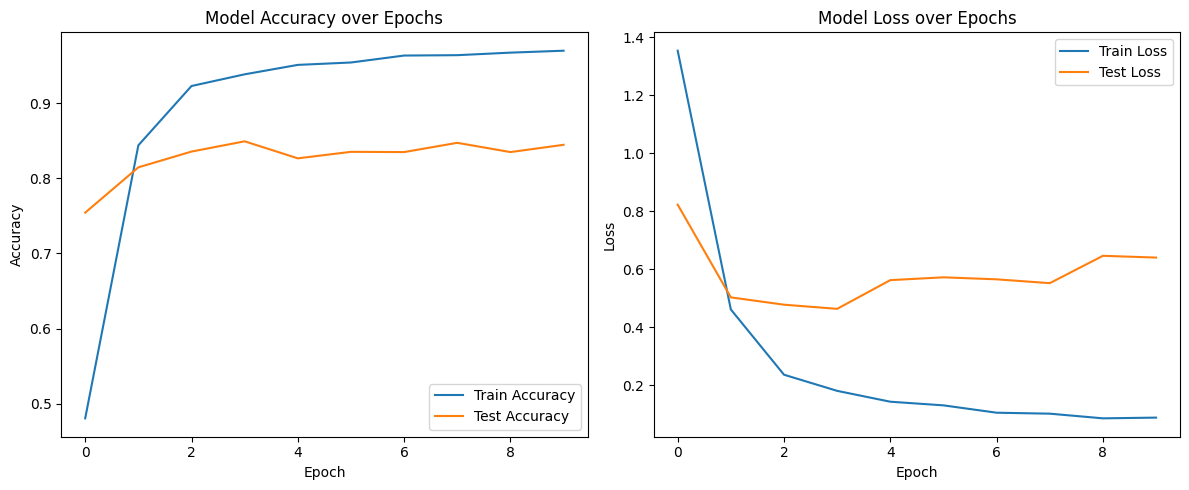

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **LSTM**

### **Build & Train Model**

In [20]:
model_1 = Sequential([
    Embedding(input_dim=16000, output_dim=100, input_length=max),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

optimizer = Adam(learning_rate=0.003)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history_1 = model_1.fit(X_train_pad, y_train_cat, epochs=10, validation_data=(X_val_pad, y_val_cat), verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 154ms/step - accuracy: 0.3187 - loss: 1.6043 - val_accuracy: 0.3540 - val_loss: 1.5711
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 77s 153ms/step - accuracy: 0.3355 - loss: 1.5755 - val_accuracy: 0.2787 - val_loss: 1.5776
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 150ms/step - accuracy: 0.3323 - loss: 1.5650 - val_accuracy: 0.4360 - val_loss: 1.1545
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 147ms/step - accuracy: 0.5239 - loss: 1.0209 - val_accuracy: 0.7863 - val_loss: 0.5439
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - accuracy: 0.8280 - loss: 0.4341 - val_accuracy: 0.8927 - val_loss: 0.3191
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - accuracy: 0.9279 - loss: 0.2184 - val_accuracy: 0.9040 - val_loss: 0.3176
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - accuracy: 0.9465 - loss: 0.1537 - val_accuracy: 0.9033 - val_loss: 0.2773
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step - accuracy: 0.9618 - loss: 0.1031 - val

### **Test Accuracy of LSTM**

In [21]:
loss_1, accuracy_1 = model_1.evaluate(X_test_pad, y_test_cat, verbose=1)
print(f"Test Accuracy: {accuracy_1 * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8928 - loss: 0.4384
Test Accuracy: 88.60%


### **LSTM Model Parameters**

In [23]:
model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (32, 35, 100)          │     1,600,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (32, 35, 256)          │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 35, 256)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (32, 64)               │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (32, 6)                │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,751,188 (21.94 MB)

 Trainable params: 1,917,062 (7.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,834,126 (14.63 MB)

### **Evaluation & Prediction**

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step
Classification Report:

              precision    recall  f1-score   support

     sadness       0.93      0.96      0.94       295
         joy       0.89      0.92      0.91       337
       anger       0.77      0.66      0.71        83
        love       0.89      0.84      0.86       140
        fear       0.86      0.87      0.87       115
    surprise       0.70      0.70      0.70        30

    accuracy                           0.89      1000
   macro avg       0.84      0.82      0.83      1000
weighted avg       0.88      0.89      0.88      1000



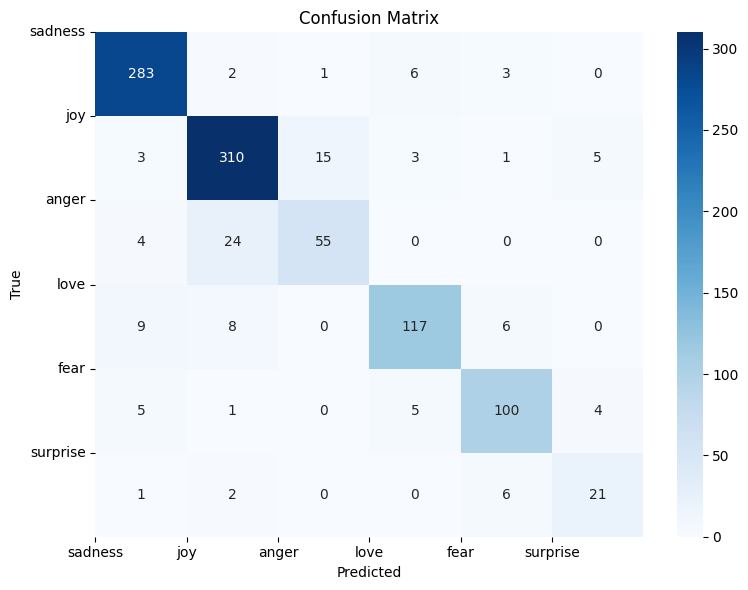

In [24]:
y_pred_probs = model_1.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

emotion_labels = ['sadness', 'joy', 'anger', 'love', 'fear', 'surprise']

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=emotion_labels))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xticks(ticks=np.arange(len(emotion_labels)), labels=emotion_labels, rotation=0)
plt.yticks(ticks=np.arange(len(emotion_labels)), labels=emotion_labels, rotation=0)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### **Accuracy vs Loss**

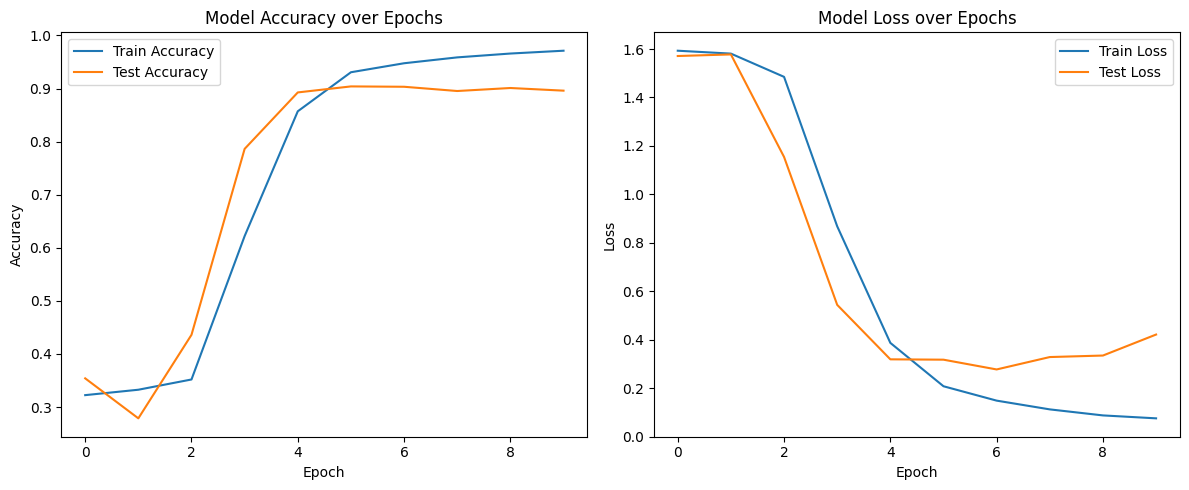

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Test Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# **Comparison: ANN VS LSTM**

In [30]:
ann_probs = model.predict(X_test_pad)
ann_preds = ann_probs.argmax(axis=1)
y_true = np.argmax(y_test_cat, axis=1)

ann_acc = accuracy_score(y_true, ann_preds)
ann_prec = precision_score(y_true, ann_preds, average='weighted')
ann_rec = recall_score(y_true, ann_preds, average='weighted')
ann_f1 = f1_score(y_true, ann_preds, average='weighted')

lstm_probs = model_1.predict(X_test_pad)
lstm_preds = lstm_probs.argmax(axis=1)
y_true = np.argmax(y_test_cat, axis=1)

lstm_acc = accuracy_score(y_true, lstm_preds)
lstm_prec = precision_score(y_true, lstm_preds, average='weighted')
lstm_rec = recall_score(y_true, lstm_preds, average='weighted')
lstm_f1 = f1_score(y_true, lstm_preds, average='weighted')

comparison_df = pd.DataFrame({
    "Model": ["ANN", "LSTM"],
    "Accuracy": [ann_acc, lstm_acc],
    "Precision": [ann_prec, lstm_prec],
    "Recall": [ann_rec, lstm_rec],
    "F1-Score": [ann_f1, lstm_f1]
})

print(comparison_df)

print(f"The best model is LSTM with Accuracy: {lstm_acc * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
  Model  Accuracy  Precision  Recall  F1-Score
0   ANN     0.836   0.834131   0.836  0.833359
1  LSTM     0.886   0.884259   0.886  0.884490
The best model is LSTM with Accuracy: 88.60%


### **Saving the Model**

In [29]:
model_1.save("lstm_emotion_model.h5")

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenize, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(labels, f)

with open("config.json", "w") as f:
    json.dump({"max_length": max}, f)